In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

In [2]:
# download historical market data (SPY)
data = yf.download("SPY", start="2010-01-01", end="2024-01-01")

/tmp/ipython-input-2-156279343.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate short moving average
short_window_size = 10

# Moving average values
short_ma_values = []

for i in range(len(data)):
  # Check if window size is within data boundaries
  # ie if 1st-9th data point cannot calculate 10 day average
  if i < short_window_size:
    short_ma_values.append(np.nan)  # Add Not a Number (NaN) for initial points where window is incomplete
  else:
    # Calculate Short MA
    short_ma_values.append(np.sum(data["Close"].values[i-short_window_size:i]) / short_window_size)

# Add the Short Moving Average column to DataFrame
data['Short MA'] = short_ma_values

In [4]:
# Calculate long moving average
long_window_size = 50

# Moving average values
long_ma_values = []

for i in range(len(data)):
  # Check if window size is within data boundaries
  if i < long_window_size:
    long_ma_values.append(np.nan)  # Add Not a Number (NaN) for initial points where window is incomplete
  else:
    # Calculate Long MA
    long_ma_values.append(np.sum(data["Close"].values[i-long_window_size:i]) / long_window_size)

# Add the Long Moving Average column to DataFrame
data['Long MA'] = long_ma_values

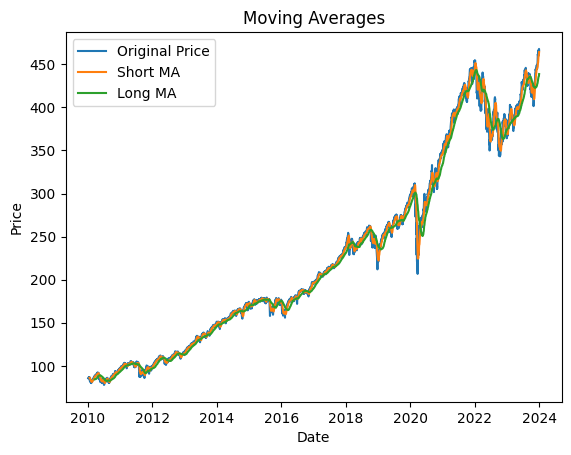

In [5]:
import matplotlib.pyplot as plt

# Plot original data, Short and long MA
plt.plot(data['Close'], label='Original Price')
plt.plot(data['Short MA'], label='Short MA')
plt.plot(data['Long MA'], label='Long MA')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Averages')
plt.legend()
plt.show()

In [6]:
# Calculate buy/sell signal each day
signal = []
for i in range(len(data)):
  if i <= long_window_size:
    signal.append(0) # no action
  else:
    # if short MA crosses from below long MA to above long MA
    if data['Short MA'].values[i-1] < data['Long MA'].values[i-1] and data['Short MA'].values[i] > data['Long MA'].values[i]:
      signal.append(1) # buy signal

    #if short MA crosses from above long MA to below long MA
    elif data['Short MA'].values[i-1] > data['Long MA'].values[i-1] and data['Short MA'].values[i] < data['Long MA'].values[i]:
      signal.append(-1) # sell signal

    else:
      signal.append(0)

# Add the Signal column to DataFrame
data['Signal'] = signal

In [7]:
look_ahead_window = 5 # look ahead 5 days to see P/L
profit = []

for i in range(len(data)):
  # if buy signal and can look ahead 5 days
  if data['Signal'].values[i] == 1 and i+look_ahead_window <= len(data):
    # if price in 5 days > current price
    if data['Close'].values[i+look_ahead_window] > data['Close'].values[i]:
      profit.append(1) # profit
    else:
      profit.append(-1) # loss
  # else if sell signal and can look ahead 5 days
  elif data['Signal'].values[i] == -1 and i+look_ahead_window <= len(data):
    # if price in 5 days < current price
    if data['Close'].values[i+look_ahead_window] < data['Close'].values[i]:
      profit.append(1) # profit
    else:
      profit.append(-1) # loss
  else:
    profit.append(0)

data['Profit'] = profit

In [8]:
# Calculate rolling volatility
daily_returns = data['Close'].pct_change()
rolling_volatility = daily_returns.rolling(window=14).std() * np.sqrt(252)

data['Rolling Volatility'] = rolling_volatility

In [9]:
# Calculate Relative Strength Index (RSI) using Wilder's smoothing
rsi_list = []

# To hold running averages for smoothing
average_gain = None
average_loss = None

for i in range(len(data)):
    if i < 14:
        rsi_list.append(np.nan)  # Not enough data yet
    else:
        # Calculate gain/loss for current day
        gain = 0
        loss = 0

        if i == 14:
            # Initial average using simple mean of first 14 values
            for j in range(1, 15):
                diff = data['Close'].values[j] - data['Close'].values[j - 1]
                diff = diff[0] # so value is stored as a float rather than a single-valued array
                if diff > 0:
                    gain += diff
                else:
                    loss += abs(diff)
            average_gain = gain / 14
            average_loss = loss / 14
        else:
            # Wilder's smoothing from the 15th index onward
            diff = data['Close'].values[i] - data['Close'].values[i - 1]
            diff=diff[0]
            gain = max(diff, 0)
            loss = abs(min(diff, 0))

            average_gain = (average_gain * 13 + gain) / 14
            average_loss = (average_loss * 13 + loss) / 14

        # Calculate RSI
        if average_loss == 0:
            RSI = 100
        else:
            RS = average_gain / average_loss
            RSI = 100 - (100 / (1 + RS))

        rsi_list.append(RSI)

data['RSI_14'] = rsi_list

In [10]:
# Calculate 10 day price slope
from sklearn.linear_model import LinearRegression

slope_list = []
price = data['Close']['SPY'].values
x = np.arange(10).reshape(-1, 1)

for i in range(len(data)):
  if i < 10:
    slope_list.append(np.nan)
  else:
    y = price[i-10:i]
    model = LinearRegression().fit(x, y)
    slope = model.coef_
    slope_list.append(slope[0])

data['10 Day Price Slope'] = slope_list

In [11]:
# Calculate volatility regime
data['Volatility Regime'] = pd.qcut(data['Rolling Volatility'], q=3, labels=[0, 1, 2]) # 0 =low, 1 = medium, 2 = high

In [12]:
# Clean column names (tuple to str)
data.columns = ['_'.join(filter(None, col)) for col in data.columns]

In [13]:
# Clean data for training - drop NaN values and unneccessary columns
feature_cols = [
    'RSI_14',
    'Rolling Volatility',
    '10 Day Price Slope',
    'Volatility Regime',
]

data_clean = data.dropna()

data_clean = data_clean[data_clean['Signal'] != 0]


# Input matrix
X = data_clean[feature_cols]

# Target label (e.g., +1 if strategy made profit, -1 otherwise)
y = data_clean['Profit']

# One hot encode vol regime
X = pd.get_dummies(X, columns=['Volatility Regime'])

#Split into training and test data
train_size = int(0.8 * len(X))  # 80% train, 20% test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [14]:
# Train Logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

          -1       0.60      0.86      0.71         7
           1       0.88      0.64      0.74        11

    accuracy                           0.72        18
   macro avg       0.74      0.75      0.72        18
weighted avg       0.77      0.72      0.72        18

